In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools, time

start_time = time.time()


In [3]:
train_path = 'data/train_set'
valid_path = 'data/valid_set'
test_path = 'data/test_set'

train_batch_size = 10 # 6000/120
valid_batch_size = 10 # #1000/20
test_batch_size = 5

train_step_per_epoch = int(6000/train_batch_size)
valid_step_per_epoch = int(2000/valid_batch_size)

In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog','cat'], batch_size=train_batch_size)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog','cat'], batch_size=valid_batch_size)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog','cat'], batch_size=test_batch_size)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Plot and Confusion matrix

In [5]:
# plot images with labels with jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False,titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
            
    f = plt.figure(figsize = figsize)
    cols = len(ims)//rows if len(ims)%2==0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
            
        plt.imshow(ims[i],interpolation=None if interp else 'none')
        

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix
    Normalization can be applied by setting 'normalize=True'
    '''
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [6]:
#imgs, labels = next(train_batches)

In [7]:
#plots(imgs, titles=labels)

## Build VGG16 model

In [8]:
vgg16_model = keras.applications.vgg16.VGG16()

In [9]:
model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [10]:
for layer in model.layers:
    layer.trainable = False

In [11]:
model.add(Dense(2, activation='softmax'))

In [12]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit_generator(train_batches, steps_per_epoch = train_step_per_epoch,
                   validation_data = valid_batches,
                   validation_steps = valid_step_per_epoch,
                   epochs = 3,
                   verbose = 2)

Epoch 1/3
 - 2085s - loss: 0.1933 - acc: 0.9502 - val_loss: 0.1892 - val_acc: 0.9590
Epoch 2/3
 - 2579s - loss: 0.1006 - acc: 0.9750 - val_loss: 0.1662 - val_acc: 0.9665
Epoch 3/3
 - 2560s - loss: 0.0831 - acc: 0.9807 - val_loss: 0.2110 - val_acc: 0.9615


## Predict using VGG16 model

[0. 0. 0. 0. 0.]
[1. 0. 0. 0. 1.]


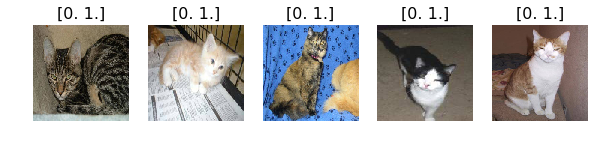

In [21]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

test_labels = test_labels[:,0]
print(test_labels)

predictions = model.predict_generator(test_batches, steps=1, verbose=0)
print(np.round(predictions[:,0]))

In [15]:
loss, accuracy = model.evaluate_generator(test_batches, steps=400, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
print('loss:',loss)
print('accuracy',accuracy)

loss: 0.17137446024798336
accuracy 0.9705000017583371


In [22]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[3 2]
 [0 0]]


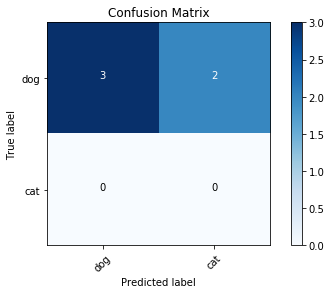

In [23]:
cm_plot_labels = ['dog','cat']
plot_confusion_matrix(cm,cm_plot_labels, title='Confusion Matrix')

In [18]:
end_time = time.time()
total_time = int(end_time - start_time)

hrs = 0
mins = 0
secs = 0

for i in range(total_time):
    secs += 1
    if secs == 60:
        mins += 1
        secs = 0
    if mins == 60:
        hrs += 1
        mins = 0
print(hrs,'hour(s)',mins,'min(s)',secs,'secs')

2 hour(s) 9 min(s) 52 secs


In [ ]:
t2 = time.time()
model.save('cats_and_dogs_model.h5')
t22 = time.time()
print(int(t22-t2),'seconds')

This save function saves:
	1. The architecture of the model, allowing to re-create the model
	2. The weights of the model
	3. The training configuration (loss, optimizer)
	4. The state of the optimizer, allowing to resume training exactly where you left off.

In [ ]:
from keras.models import load_model
#new_model = load_model('cats_and_dogs_model.h5')

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('cats_and_dogs_model.h5')


In [ ]:
# save as json
json_string = model.to_json()

# save as YAML
# yaml_string = model.to_yaml()

In [ ]:
json_string

In [ ]:
# model reconstruction from JSON:
from keras.models import model_from_json
model_architecture = model_from_json(json_string)

# model reconstruction from JAML
# from keras.models import model_from_yaml
# model = model_from_yaml(yaml_string)

model_architecture.summary()

In [ ]:
## model.save_weights()

model.save_weights('my_model_weights.h5')

In [ ]:
# model2 = Sequential([....])

In [ ]:
model2.load_weights('my_model_weights.h5')